In [1]:
import json
import pickle
from itertools import chain

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from neuron import h
h.load_file('stdrun.hoc')
h.cvode_active(1)

from dlutils import utils
from dlutils.cell import Cell, branch_order
from dlutils.synapse import AMPAExp2Synapse, NMDAExp2Synapse
from dlutils.spine import Spine
from dlutils.numerics import double_exp

> /Users/daniele/local/lib/python3.7/site-packages/neuron/__init__.py(105)<module>()
-> import sys
(Pdb) c


### General parameters

In [2]:
cell_type = 'a-thorny'
optimization_folder = '/Users/daniele/Postdoc/Research/Janelia/01_model_optimization/'

if cell_type == 'thorny':
    base_folder = optimization_folder + 'Thorny/DH070813/20191208071008_DH070813_/'
    swc_file = 'DH070813-.Edit.scaled.converted.swc'
    cell_name = 'DH070813_'
    individual = 1
else:
    base_folder = optimization_folder + 'A-thorny/DH070213C3/20191206232623_DH070213C3_/'
    swc_file = 'DH070213C3-.Edit.scaled.converted.swc'
    cell_name = 'DH070213C3_'
    individual = 0
    
swc_file = base_folder + swc_file
params_file = base_folder + 'individual_{}.json'.format(individual)
config_file = base_folder + 'parameters.json'

passive = False
with_TTX = True
replace_axon = True
add_axon_if_missing = True
parameters = json.load(open(params_file, 'r'))
mechanisms = utils.extract_mechanisms(config_file, cell_name)
sim_pars = pickle.load(open(base_folder + 'simulation_parameters.pkl','rb'))
replace_axon = sim_pars['replace_axon']
add_axon_if_missing = not sim_pars['no_add_axon']

### Instantiate the cell

In [3]:
cell = Cell('CA3_cell_%d' % int(np.random.uniform()*1e5), swc_file, parameters, mechanisms)
cell.instantiate(replace_axon, add_axon_if_missing, force_passive=passive, TTX=with_TTX)
if cell_type == 'thorny':
    section_num = 7
    segment_x = 0.5
    weights_0 = np.array([0.04, 0.1])
else:
    section_num = 16
    segment_x = 0.9
    weights_0 = np.array([0.04, 0.1])

section = cell.morpho.apic[section_num]
segment = section(segment_x)
Ra = section.Ra

One point section Import3d_Section[2] ending at line 3 has been removed
One point section Import3d_Section[1] ending at line 2 has been removed


In [4]:
for seg in cell.apical_segments:
    if seg['seg'] == segment:
        break
segment_dst = seg['dst']
segment_diam = segment.diam
segment_branch_order = branch_order(section)

In [5]:
def compute_Rin(seg, I0, do_plot=False):
    stim = h.IClamp(seg)
    stim.delay = 500
    stim.amp = I0
    stim.dur = 200

    rec = {}
    for lbl in 't','V':
        rec[lbl] = h.Vector()
    rec['t'].record(h._ref_t)
    rec['V'].record(seg._ref_v)

    h.tstop = 1000
    h.run()
    
    t = np.array(rec['t'])
    V = np.array(rec['V'])
    idx, = np.where(t < stim.delay)
    V0 = V[idx[-10]]
    idx, = np.where(t < stim.delay + stim.dur)
    V1 = V[idx[-10]]
    dV = V1 - V0
    Rin = dV / stim.amp
    
    if do_plot:
        plt.plot(t, V, 'k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Vm (mV)')
        plt.xlim([480,800]);

    stim.amp = 0
    return Rin

### Instantiate the spine

In [6]:
# in the Harnett paper, the head is spherical with a diameter of 0.5 um: a cylinder
# with diameter and length equal to 0.5 has the same (outer) surface area as the sphere
head_L = 0.5
head_diam = 0.5
neck_L = 1.58
neck_diam = 0.077
spine = Spine(section, segment.x, head_L, head_diam, neck_L, neck_diam, Ra)
spine.instantiate()

Spine axial resistivity: 341.46 Ohm cm.


### Compute the input resistance of the dendrite

In [7]:
R_dend = compute_Rin(segment, -0.1, False)
print('R_dend = {:.1f} MOhm.'.format(R_dend))

R_dend = 1617.5 MOhm.


#### Show where the spine is located on the dendritic tree

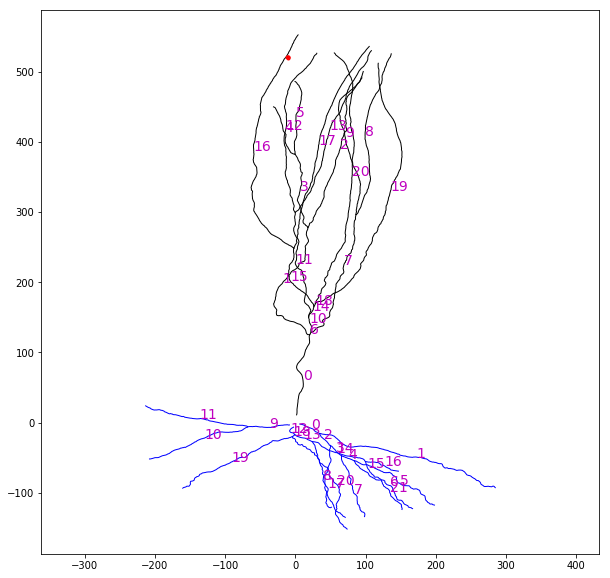

In [8]:
plt.figure(figsize=(10,10))
for sec in chain(cell.morpho.apic, cell.morpho.basal):
    if sec in cell.morpho.apic:
        color = 'k'
    else:
        color = 'b'
    lbl = sec.name().split('.')[1].split('[')[1][:-1]
    n = sec.n3d()
    sec_coords = np.zeros((n,2))
    for i in range(n):
        sec_coords[i,:] = np.array([sec.x3d(i), sec.y3d(i)])
    middle = int(n / 2)
    plt.text(sec_coords[middle,0], sec_coords[middle,1], lbl, \
             fontsize=14, color='m')
    plt.plot(sec_coords[:,0], sec_coords[:,1], color, lw=1)
plt.plot(spine._points[:,0], spine._points[:,1], 'r.')
plt.axis('equal');

1) optimize the weights to have a comparable deflection in the spine when injecting current in both the spine and the dendrite
<br/>
2) compute the amplitude ratio of the EPSPs in the spine and in the dendrite when injecting current in the spine

In [9]:
def cost(weights, target_dV, vec, time, EPSP, rec, t_onset):
    locations = list(target_dV.keys())
    
    for i,k in enumerate(locations):
        for j in range(len(time)):
            vec[k][j] = EPSP[k][j] * weights[i]
    h.tstop = time[-1]
    h.run()
    
    t = np.array(rec['t'])
    V = {k: np.array(rec[k]) for k in locations}
    idx, = np.where(t < t_onset['dend'] - 10)
    V0 = {k: V[k][idx[-1]] for k in locations}
    idx, = np.where(t < t_onset['dend'] + 50)
    dV = {}
    dV['dend'] = np.max(V['dend'][idx]) - V0['dend']
    idx, = np.where(t > t_onset['dend'] + 50)
    dV['spine'] = np.max(V['spine'][idx]) - V0['spine']
    return np.sum([np.abs(target_dV[k] - dV[k]) for k in locations])

In [10]:
locations = ['spine', 'dend']
seg = {'spine': spine.head(1), 'dend': spine._sec(0.8)}
t_onset = {'spine': 350, 'dend': 150}
weights = [0.1, 0.1]

tr = 1
td = 10
t_end = 400
dt = 0.1
time = np.arange(0, t_end, dt)
EPSP = {k: double_exp(tr, td, t_onset[k], time) for k in t_onset}

vec = {}
vec['time'] = h.Vector(time)
for i,k in enumerate(locations):
    vec[k] = h.Vector(EPSP[k])

stimuli = {k: h.IClamp(seg[k]) for k in seg}
rec = {'t': h.Vector(), 'soma': h.Vector()}
rec['t'].record(h._ref_t)
rec['soma'].record(cell.morpho.soma[0](0.5)._ref_v)
for k in locations:
    stimuli[k].dur = 10 * t_end
    rec[k] = h.Vector()
    rec[k].record(seg[k]._ref_v)
    
for i,k in enumerate(locations):
    vec[k].play(stimuli[k]._ref_amp, vec['time'], 1)
    
h.cvode_active(1)

1.0

In [11]:
target_dV = {k: 20. for k in locations}
opt = minimize(lambda x: cost(x, target_dV, vec, time, EPSP, rec, t_onset), \
               weights_0, \
               bounds = [(0,1), (0,1)], \
               options = {'maxiter': 20, 'disp': True})
locations.append('soma')

In [12]:
opt

      fun: 3.4440083496178886e-06
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1541.4881446 ,  652.85739979])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 546
      nit: 18
   status: 2
  success: False
        x: array([0.00494153, 0.01171209])

Cost: 3.444e-06.


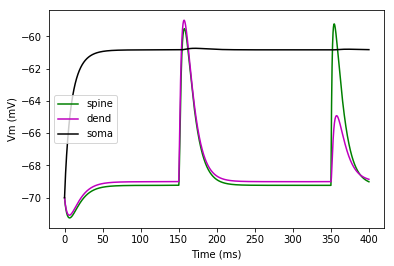

In [13]:
weights = opt['x']
c = cost(weights, target_dV, vec, time, EPSP, rec, t_onset)
print('Cost: {:.3e}.'.format(c))
col = {'spine': 'g', 'dend': 'm', 'soma': 'k'}
for k in locations:
    plt.plot(rec['t'], rec[k], col[k], label=k)
plt.legend(loc='best')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)');

In [14]:
t = np.array(rec['t'])
V = {k: np.array(rec[k]) for k in locations}
idx, = np.where(t < t_onset['dend'] - 10)
V0 = {k: V[k][idx[-1]] for k in locations}
idx, = np.where(t < t_onset['dend'] + 50)
dend_to_spine_dV = {}
dend_to_spine_dV = {k: np.max(V[k][idx]) - V0[k] for k in locations}
idx, = np.where(t > t_onset['dend'] + 50)
spine_to_dend_dV = {k: np.max(V[k][idx]) - V0[k] for k in locations}

AR = spine_to_dend_dV['spine'] / spine_to_dend_dV['dend']

R_neck = (AR - 1) * R_dend

print('Current injected in the dendrite:')
print('   Dendrite deflection: {:.3f} mV.'.format(dend_to_spine_dV['dend']))
print('      Spine deflection: {:.3f} mV.'.format(dend_to_spine_dV['spine']))
print('    Somatic deflection: {:.3f} mV.'.format(dend_to_spine_dV['soma']))
print('')
print('Current injected in the spine:')
print('      Spine deflection: {:.3f} mV.'.format(spine_to_dend_dV['spine']))
print('   Dendrite deflection: {:.3f} mV.'.format(spine_to_dend_dV['dend']))
print('    Somatic deflection: {:.3f} mV.'.format(spine_to_dend_dV['soma']))
print('')
print('Amplitude ratio: {:.2f}.'.format(AR))
print('')
print('R_neck: {:.1f} MOhm.'.format(R_neck))

Current injected in the dendrite:
   Dendrite deflection: 10.000 mV.
      Spine deflection: 9.707 mV.
    Somatic deflection: 0.096 mV.

Current injected in the spine:
      Spine deflection: 10.000 mV.
   Dendrite deflection: 4.089 mV.
    Somatic deflection: 0.040 mV.

Amplitude ratio: 2.45.

R_neck: 2338.0 MOhm.


In [15]:
data = {'dend_to_spine_dV': dend_to_spine_dV, 'spine_to_dend_dV': spine_to_dend_dV,
        'AR': AR, 'R_dend': R_dend, 'R_neck': R_neck, 'target_dV': target_dV,
        'weights': weights, 'cost_fun': c, 'section_num': section_num, 'segment_x': segment_x,
        'Ra': Ra, 'passive': passive, 'with_TTX': with_TTX, 'head_L': head_L, 'head_diam': head_diam,
        'neck_L': neck_L, 'neck_diam': neck_diam, 'segment_dst': segment_dst, 'segment_diam': segment_diam,
        'segment_branch_order': segment_branch_order}
data

{'dend_to_spine_dV': {'spine': 9.707208827310694,
  'dend': 9.999998970340584,
  'soma': 0.09554759967542026},
 'spine_to_dend_dV': {'spine': 9.999997585651066,
  'dend': 4.089179868808785,
  'soma': 0.03985805531325326},
 'AR': 2.4454775545405774,
 'R_dend': 1617.4561348189036,
 'R_neck': 2337.996538334683,
 'target_dV': {'spine': 10.0, 'dend': 10.0},
 'weights': array([0.00494153, 0.01171209]),
 'cost_fun': 3.4440083496178886e-06,
 'section_num': 16,
 'segment_x': 0.9,
 'Ra': 341.4626706091646,
 'passive': True,
 'with_TTX': False,
 'head_L': 0.5,
 'head_diam': 0.5,
 'neck_L': 1.58,
 'neck_diam': 0.077,
 'segment_dst': 619.7123343279753,
 'segment_diam': 0.6600274530473286,
 'segment_branch_order': 6}